In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_dir = Path('/auto/plzen1/home/romanb/MassIVE_data')
df = pd.read_csv(data_dir / '11442_foodomics_multiproject_metadata_20200630_submission.txt', sep='\t')
df['name'] = df['filename'].apply(lambda x: x.split('.')[0])
df = df.drop_duplicates(subset=['name'])
df = df.set_index('name')
df

,filename,sample_name,description,simple_complex,sample_type,sample_type_aquatic_land,sample_type_group1,sample_type_group2,sample_type_group3,sample_type_group4,...,upc,vegan,Vendor_store,washed_not,washed_specific,brand_roast_unique,host_subject_id,barcode_number,image_taken,image_on_Massive
name,,,,,,,,,,,,,,,,,,,,,
15NAVY01_V1_ALL_GB2_01_39810,15NAVY01_V1_ALL_GB2_01_39810.mzXML,15NAVY01_V1_ALL,15NAVY01_V1_ALL,complex,food,complex,complex,complex,complex,complex,...,not collected,not entered,not entered,not entered,not applicable,not applicable,15NAVY01_V1_ALL,not applicable,no,False
15NAVY01_V1_breakfast_GA7_01_39806,15NAVY01_V1_breakfast_GA7_01_39806.mzXML,15NAVY01_V1_breakfast,15NAVY01_V1_breakfast,complex,food,complex,complex,complex,complex,complex,...,not collected,not entered,not entered,not entered,not applicable,not applicable,15NAVY01_V1_breakfast,not applicable,no,False
15NAVY01_v1_brk_1_GA4_01_39548,15NAVY01_v1_brk_1_GA4_01_39548.mzXML,15NAVY01_v1_brk_1,"**Peanut Butter Smooth, 8/14",complex,food,land,plant,fruit,legume,legume,...,not collected,not entered,not entered,not entered,not applicable,not applicable,15NAVY01_v1_brk_1,not applicable,yes,False
15NAVY01_v1_brk_2_GB4_01_39546,15NAVY01_v1_brk_2_GB4_01_39546.mzXML,15NAVY01_v1_brk_2,Honey Nut Cheerios,complex,food,land,plant,fruit,grain/grass,complex,...,not collected,not entered,not entered,not entered,not applicable,not applicable,15NAVY01_v1_brk_2,not applicable,yes,False
15NAVY01_v1_brk_3_GC4_01_39547,15NAVY01_v1_brk_3_GC4_01_39547.mzXML,15NAVY01_v1_brk_3,"Bread White, Aspen",complex,food,land,plant,fruit,grain/grass,complex,...,not collected,not entered,not entered,not entered,not applicable,not applicable,15NAVY01_v1_brk_3,not applicable,yes,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VA5_2x_RB5_01_21614,VA5_2x_RB5_01_21614.mzXML,VA5,spinach salad,complex,food,land,plant,complex,complex,complex,...,not entered,not entered,not entered,not entered,not entered,not entered,not entered,not entered,not entered,False
VA6_2x_RB6_01_21615,VA6_2x_RB6_01_21615.mzXML,VA6,Fish baked,complex,food,complex,complex,complex,complex,complex,...,not entered,not entered,not entered,not entered,not entered,not entered,not entered,not entered,not entered,False
VA7_2x_RB7_01_21616,VA7_2x_RB7_01_21616.mzXML,VA7,cheese pasta,complex,food,land,complex,complex,complex,complex,...,not entered,not entered,not entered,not entered,not entered,not entered,not entered,not entered,not entered,False


In [3]:
f = h5py.File(data_dir / 'MSV000084900_merged_MSn_DreaMS.hdf5')
print(f.keys())
sample_names = pd.Series(f['file_name'][:]).apply(lambda x: x.decode('utf-8')).apply(lambda x: '_'.join(x.split('_')[1:]))
sample_names = sample_names.values
sample_names

<KeysViewHDF5 ['DreaMS_Embedding', 'MS level', 'RT', 'charge', 'def str', 'energy', 'file_name', 'ion injection time', 'positive polarity', 'precursor id', 'precursor mz', 'spectrum', 'type', 'window lo', 'window uo']>


array(['G73505_1x_10ul_RB4_01_18621', 'G73505_1x_10ul_RB4_01_18621',
       'G73505_1x_10ul_RB4_01_18621', ..., 'G86964_1x_RC12_01_23520',
       'G86964_1x_RC12_01_23520', 'G86964_1x_RC12_01_23520'], dtype=object)

In [4]:
df_avg_embs, avg_embs = [], []
for name in tqdm(np.unique(sample_names)):
    if name not in df.index.values:
        # print(f'{name} is not present in the metadata table.')
        continue

    name_idx = np.where(sample_names == name)[0]
    if len(name_idx) < 1000:
        print(f'{name} has less than 1000 spectra.')
        continue

    embs = f['DreaMS_Embedding'][name_idx]
    avg_emb = embs.mean(axis=0)
    avg_embs.append(avg_emb)

    df_avg_embs.append({
        'name': name,
        'description': df['description'].loc[name],
        'num_spectra': embs.shape[0]
    })
df_avg_embs = pd.DataFrame(df_avg_embs)
avg_embs = np.stack(avg_embs)
print(avg_embs.shape)
df_avg_embs

 69%|█████████████████████████████████████████████████████████████████████████▊                                 | 2399/3476 [06:16<01:41, 10.58it/s]

G86965_1x_RD2_01_23523 has less than 1000 spectra.


 71%|████████████████████████████████████████████████████████████████████████████                               | 2470/3476 [06:27<02:26,  6.88it/s]

G87365_1x_BA7_01_25987 has less than 1000 spectra.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 3476/3476 [09:13<00:00,  6.28it/s]

(2810, 1024)


,name,description,num_spectra
0,72442_1x_BD9_01_17436,pea in chicken biryani,2272
1,72443_1x_BE8_01_17448,carrot in chicken biryani,2306
2,72444_1x_BD8_01_17435,persian cucumber in chicken biryani,2262
3,72445_1x_BC8_01_17426,raw tomato in chicken biryani,2236
4,72475_1x_BC9_01_17418,garlic,1596
...,...,...,...
2805,sample_20_RB10_01_49368,mama dutasi,2501
2806,sample_6_RA7_01_49342,INT-A,2514
2807,sample_7_RA8_01_49344,TUKARA,2459
2808,sample_8_RA9_01_49345,TUKARA,2473


In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# from scipy.cluster.hierarchy import dendrogram, linkage
# from scipy.spatial.distance import squareform
# pairwise_sims = cosine_similarity(avg_embs, avg_embs)
# pairwise_sims.shape

# i = 190
# k = 10
# # sns.heatmap(pairwise_sims[:k], linewidth=0.5, annot=True, xticklabels=foods[:k], yticklabels=foods)
# topk_idx = np.argsort(pairwise_sims[i], axis=0)[::-1][:k]
# print(foods[i], df['description'].loc[foods[i]])
# for j in topk_idx[1:]:
#     print(pairwise_sims[i, j], foods[j], df['description'].loc[foods[j]])

In [21]:
import collections as coll
import pandas as pd
import numpy as np
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
import matplotlib as mpl
import termplotlib as tpl

def init_plotting(figsize=(6, 2), font_scale=0.95, style='whitegrid', cmap='plotly', font=None, legend_outside=False):
    # Set default figure size
    plt.show()  # Does not work without this line for some reason
    sns.set(rc={'figure.figsize': figsize})
    # Set default style and  font scale
    sns.set_style(style)
    sns.set_context('paper', font_scale=font_scale)
    sns.set_palette(['#2664BF', '#34A89A', '#F69CA9', '#FBD399', '#A8A9AB', '#AD95D1', '#AB8D8B', '#FEA992',
                     '#6A4C93', '#C7EFCF', '#00CED1', '#FF6347', '#FF6F61'])
    if not font:
        mpl.rcParams['svg.fonttype'] = 'none'
        # mpl.rcParams['pdf.fonttype'] = 42  # For Adobe Illustrator
        # mpl.rcParams['ps.fonttype'] = 42  # For Adobe Illustrator
    else:
        mpl.rcParams['font.family'] = font
    if legend_outside:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

def save_fig(name, dir=None, dpi=None, transparent=True):
    plt.savefig((dir / name) if dir is not None else name, bbox_inches='tight', pad_inches=0.05, dpi=dpi,
                transparent=transparent)

In [16]:
import re

def contains_word(s, w):
    return f'\\b{w}\\b' in re.findall(r'\\b\\w+\\b', s)

def categorize_item(name):
    name_lower = name.lower()

    categories = {
        "Sweets & Snacks": [
            "sweet", "snack", "chocolate", "cookie", "candy", "cake", "dessert", "gummy bear", "marshmallow", "lollipop",
            "donut", "ice cream", "pie", "pudding", "jelly", "pastry", "croissant", "muffin", "scone", "tart", "eclair",
            "macaron", "ritter"
        ],
        "Specialized Nutrition": [
            "peptamen junior", "pediasure", "ensure", "nutritional supplement", "protein shake", "meal replacement"
        ],
        "Cheese & Dairy Products": [
            "cheese", "yogurt", "milk", "butter", "cream", "ghee", "ice cream", "kefir", "sour cream", "mozzarella",
            "cheddar", "feta", "curd", "custard", "parmesan", "chabichou", "epoisse", "robiola", "gorgonzola",
            "brie", "camembert", "ricotta", "pecorino", "stilton", "manchego", "taleggio", "roquefort", "bleu",
            "mascarpone"
        ],
        "Beverages": [
            "champagne", "coffee", "tea", "juice", "smoothie", "beer", "sake", "wine", "water", "soda", "lemonade",
            "milkshake", "cocktail", "espresso", "latte", "cappuccino"
        ],
        "Meat, Poultry & Seafood": [
            "meat", "poultry", "seafood", "chicken", "fish", "beef", "pork", "turkey", "salmon", "catfish", "anchovy",
            "sausage", "horse", "lamb", "duck", "steak", "ham", "bacon", "chorizo", "rib", "shank", "fillet", "loin"
        ],
        "Vegetables": [
            "vegetable", "carrot", "cucumber", "lettuce", "tomato", "spinach", "kale", "pepper", "asparagus", "avocado",
            "zucchini", "mushroom", "onion", "cabbage", "kohlrabi", "beet", "broccoli", "cauliflower", "chili", "corn",
            "eggplant", "garlic", "green bean", "leek", "pea", "potato", "radish", "squash", "sweet potato", "turnip",
            "artichoke", "celery", "parsnip"
        ],
        "Fruits & Berries": [
            "fruit", "berry", "blueberry", "orange", "grape", "strawberry", "melon", "fig", "apple", "pear", "cherry",
            "apricot", "peach", "cranberry", "banana", "mango", "lychee", "kiwi", "lemon", "lime", "blackberry",
            "raspberry", "pomegranate", "watermelon", "pineapple", "grapefruit", "plum", "pumpkin", "date", "persimmon",
            "papaya"
        ],
        "Grains & Cereals": [
            "grain", "cereal", "rice", "pasta", "bread", "naan", "quinoa", "oats", "barley", "cornmeal", "flour", "millet",
            "rye", "wheat", "buckwheat", "semolina", "spaghetti", "noodle", "bulgur", "couscous", "farro", "polenta"
        ],
        "Herbs & Spices": [
            "herb", "spice", "basil", "garlic", "rosemary", "cilantro", "cardamom", "turmeric", "ginger", "peppermint",
            "cinnamon", "clove", "coriander", "cumin", "dill", "fennel", "oregano", "paprika", "saffron", "thyme", "vanilla",
            "parsley", "chive"
        ],
        "Nuts & Seeds": [
            "nut", "seed", "pine nut", "sunflower seed", "chia seed", "hemp seed", "almond", "cashew", "peanut", "pistachio",
            "walnut", "pumpkin seed", "sesame seed", "flaxseed", "poppy seed"
        ],
        "Fermented & Pickled": [
            "fermented", "pickle", "kimchi", "sauerkraut", "dulse", "tempeh", "miso", "pickled", "brine", "ferment"
        ],
        "Condiments, Sauces & Oils": [
            "condiment", "sauce", "oil", "soy sauce", "mustard", "dressing", "vinegar", "ketchup", "mayonnaise", "relish",
            "hot sauce", "bbq sauce", "salad dressing", "teriyaki", "salsa", "olive oil", "coconut oil", "sesame oil"
        ],
        "Miscellaneous": [
            "probiotic", "yeast", "matcha", "hummus", "tempeh", "tahini", "supplement", "extract", "powder", "drink mix",
            "meal replacement", "protein powder", "vitamin", "mineral"
        ]
    }

    # Check for direct and whole word matches
    for category, keywords in categories.items():
        for keyword in keywords:
            pattern = r'\b' + re.escape(keyword) + r'\b'
            if re.search(pattern, name_lower, re.IGNORECASE):
                return category

    return "Miscellaneous"

df_avg_embs['category'] = df_avg_embs['description'].apply(categorize_item)
df_avg_embs['category'].value_counts()

category
Miscellaneous                948
Beverages                    387
Meat, Poultry & Seafood      306
Vegetables                   286
Cheese & Dairy Products      285
Fruits & Berries             196
Sweets & Snacks              141
Grains & Cereals              99
Herbs & Spices                60
Condiments, Sauces & Oils     42
Nuts & Seeds                  41
Fermented & Pickled           14
Specialized Nutrition          5
Name: count, dtype: int64

6 0.55


/storage/brno2/home/romanb/.conda/envs/tmap_env/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


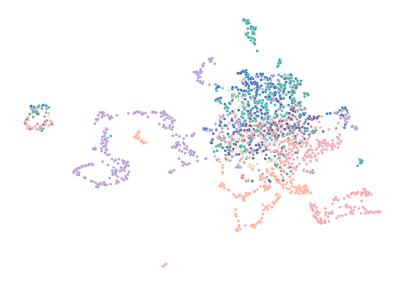

In [34]:
import umap
palette = ['#F69CA9', '#34A89A', '#2664BF', '#FBD399', '#A8A9AB', '#AD95D1', '#AB8D8B', '#FEA992',
           '#C7EFCF', '#6A4C93', '#00CED1', '#FF6F61']
init_plotting(figsize=(5, 3), style='white')

non_misc_idx = df_avg_embs[df_avg_embs['category'] != 'Miscellaneous'].index.tolist()
non_misc_embs = avg_embs[non_misc_idx]
non_misc_df_avg_embs = df_avg_embs.iloc[non_misc_idx]

for n in [6]:#[3, 4, 5, 6, 7]:  #, 10, 20, 30, 40]:
    for m in [0.55]:  # 0.1, 0.2, 0.25, 0.3,
        print(n, m)
        reducer = umap.UMAP(metric='cosine', n_neighbors=n, min_dist=m, n_components=2, random_state=42)
        umap_ebms = reducer.fit_transform(non_misc_embs)
        init_plotting(figsize=(7, 5))
        sns.scatterplot(x=umap_ebms[:, 0], y=umap_ebms[:, 1], hue=non_misc_df_avg_embs['category'], s=8, alpha=0.9, palette=palette)
        # Show legend on bottom
        # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
        plt.legend('', frameon=False)
        plt.grid(None)
        plt.axis('off')
        plt.xticks([])
        plt.yticks([])
        save_fig(f'umap_foodomics.png', dir=Path('/storage/plzen1/home/romanb/figures'), dpi=300)
        plt.show()

In [37]:
import plotly.express as px
fig = px.scatter(x=umap_ebms[:, 0], y=umap_ebms[:, 1], hover_data=[list(range(len(non_misc_df_avg_embs)))] + [non_misc_df_avg_embs[c].values for c in non_misc_df_avg_embs.columns], color=non_misc_df_avg_embs['category'], width=1200, height=700, color_discrete_sequence=px.colors.qualitative.Light24)
fig.write_html('/storage/plzen1/home/romanb/figures/umap_foodomics.html')
fig.show()